# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler
import copy


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, GRU


sns.set(font_scale=1.5)

# Functions

In [3]:
def create_dataset(x, y, time_steps=1):
    xs, ys = [], []  # Initialize output lists
    for i in range(len(x) - time_steps):
        v = x[i:(i + time_steps), :]  # Slice input data
        xs.append(v)  # Append slice to input list
        ys.append(y[i + time_steps])  # Append corresponding output to output list
    return np.array(xs), np.array(ys)  # Return data as numpy arrays

In [20]:
def make_RNN_model(input_shape, layers_lstm, return_sequences, dense_layers, activation, output, activation_out):
    model = []
    model.append(tf.keras.layers.LSTM(units=layers_lstm[0], return_sequences=return_sequences[0], input_shape=input_shape))
    for i in range(1, len(layers_lstm)):
        model.append(tf.keras.layers.LSTM(units=layers_lstm[i], return_sequences=return_sequences[i]))

    for dl in dense_layers:
        model.append(tf.keras.layers.Dense(dl, activation=activation))

    model.append(tf.keras.layers.Dense(output, activation=activation_out))
    model = tf.keras.Sequential(model)

    return model

In [21]:
def train_RNN_network(train, test, layers_lstm, return_sequences, dense_layers, activation, output, activation_out, start_lag, end_lag, epochs, batch_size, opt, loss, factor=0.8, patience_reduce=10, patience_early=15):
    dict_results = {'Lags': [], 'MAE': [], 'MSE': []}
    for i in range(start_lag, end_lag+1):
        x_train, y_train = create_dataset(train, train, i)
        x_test, y_test = create_dataset(test, test, i)

        model = make_RNN_model((i,1), layers_lstm, return_sequences, dense_layers, activation, output, activation_out)

        init_w = opt.get_weights()
        model_tmp = tf.keras.models.clone_model(model)
        opt.set_weights(init_w)
        model_tmp.compile(optimizer=opt, loss=loss, metrics=['mae', 'mse'])
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=factor, patience=patience_reduce)
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early, restore_best_weights=True)
        history = model_tmp.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[reduce_lr, early_stopping])

        y_pred = model_tmp.predict(x_test, verbose=0, batch_size=batch_size)
        #y_pred = scaler.inverse_transform(y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        dict_results['MAE'].append(mae)
        dict_results['MSE'].append(mae)
        dict_results['Lags'].append(i)

        print('MAE:', mae, 'and MSE:', mse, 'for', i, 'lags')
    return pd.DataFrame(dict_results)

# About Dataset
This dataset is the most up-to-date kaggle dataset about daily sunspot counts with no missing values. The source data originate from the World Data Center SILSO, Royal Observatory of Belgium, Brussels.

The Daily total sunspot number is derived by the formula: R = Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk. The original data contained some values between 1818 and 1850 but I removed those years because there was too much missing values.


**Error values**

Those values correspond to the standard deviation of raw numbers provided by all stations.

* Before 1981, the errors are estimated with the help of an auto-regressive model based on the Poissonian distribution of actual Sunspot Numbers.
* From 1981 onwards, the error value is the actual standard deviation of the sample of raw observations used to compute the daily value.

**The standard error of the daily Sunspot Number can be computed by:**

sigma/sqrt(N) where sigma is the listed standard deviation and N the number of observations for the day.
Before 1981, the number of observations is set to 1, as the Sunspot Number was then essentially the raw Wolf number from the Zürich Observatory.


**Columns Description**

* Column 1-3: Gregorian calendar date
    * Year
    * Month
    * Day
* Column 4: Date in fraction of year
*  Column 5: Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value): there should not be any missing values as I removed all years before 1850 where there was missing values.
* Column 6: Daily standard deviation of the input sunspot numbers from individual stations.
* Column 7: Number of observations used to compute the daily value.
* Column 8: Definitive/provisional indicator. A blank (NaN) indicates that the value is definitive. A '*' symbol indicates that the value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)

# Read data

In [6]:
df = pd.read_csv('sunspots_1850_2023.csv')
df.head()

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN


# Check empty values

In [7]:
df.isna().sum()

date             0
year             0
month            0
day              0
date_frac        0
counts           0
std              0
nobs             0
indicator    63277
dtype: int64

# Make monthly mean dataset

In [8]:
df = pd.DataFrame(df.groupby(pd.PeriodIndex(df['date'], freq="M"))['counts'].mean())
df = df.reset_index()
df['date'] = df['date'].dt.to_timestamp('s').dt.strftime('%Y-%m')
df = df.set_index('date')
df.head()

,counts
date,
1850-01,148.225806
1850-02,169.750000
1850-03,156.838710
1850-04,83.833333
1850-05,117.032258


# Plot sunspots monthly mean by time

(array([   0,  120,  240,  360,  480,  600,  720,  840,  960, 1080, 1200,
        1320, 1440, 1560, 1680, 1800, 1920, 2040]),
 [Text(0, 0, '1850-01'),
  Text(120, 0, '1860-01'),
  Text(240, 0, '1870-01'),
  Text(360, 0, '1880-01'),
  Text(480, 0, '1890-01'),
  Text(600, 0, '1900-01'),
  Text(720, 0, '1910-01'),
  Text(840, 0, '1920-01'),
  Text(960, 0, '1930-01'),
  Text(1080, 0, '1940-01'),
  Text(1200, 0, '1950-01'),
  Text(1320, 0, '1960-01'),
  Text(1440, 0, '1970-01'),
  Text(1560, 0, '1980-01'),
  Text(1680, 0, '1990-01'),
  Text(1800, 0, '2000-01'),
  Text(1920, 0, '2010-01'),
  Text(2040, 0, '2020-01')])

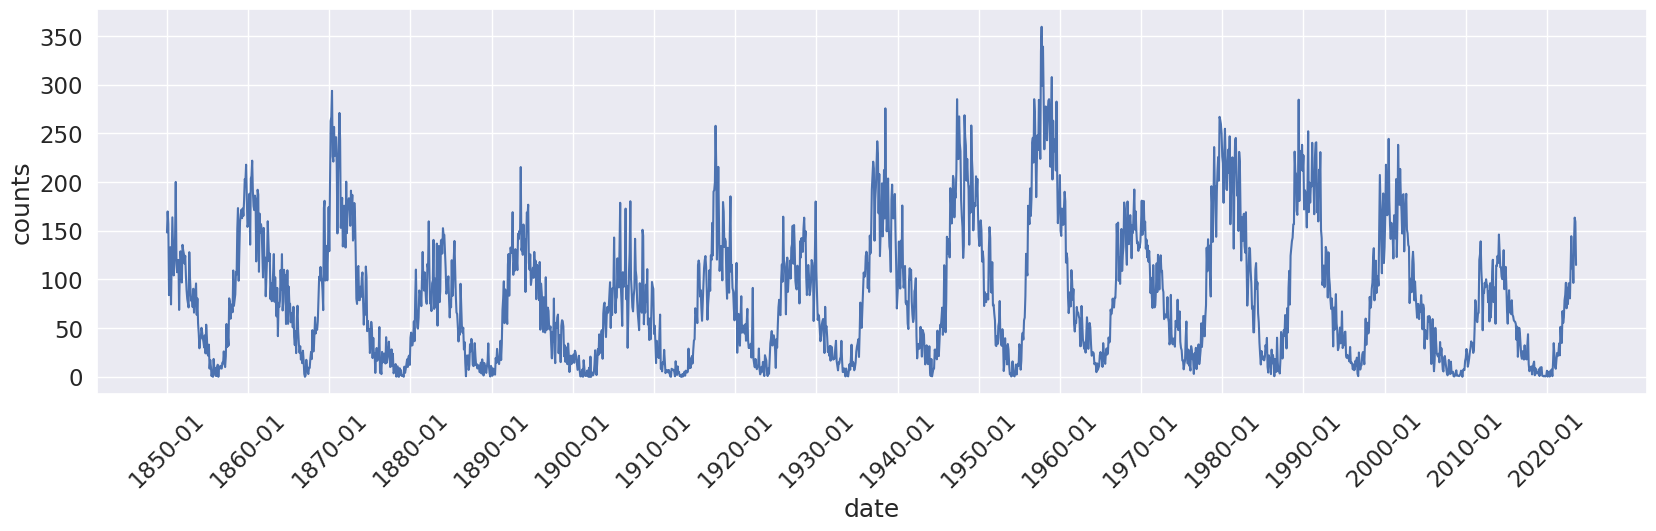

In [9]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(y=df['counts'], x=df.index)
ax.set_xticks(ax.get_xticks()[::120])
plt.xticks(rotation=45)

In [10]:
df.describe()

,counts
count,2084.000000
mean,83.278656
std,67.781544
min,0.000000
25%,24.174194
50%,71.032258
75%,126.445968
max,359.387097


# Splitting and scale data

In [11]:
split = int(len(df) * 0.9)
split

1875

In [12]:
scaler  = MinMaxScaler() # scaler
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled = df_scaled.rename(columns = {0: 'monthly_mean'})
df_scaled.head()

,monthly_mean
0,0.412441
1,0.472332
2,0.436406
3,0.233268
4,0.325644


In [13]:
df_train = df_scaled[:split].to_numpy()
df_test = df_scaled[split:].to_numpy()

# Train RNN

In [79]:
opt = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-2, epsilon=1e-10)
scores = train_RNN_network(train=df_train, test=df_test, layers_lstm=[64,64,32], return_sequences=[True, True, False], dense_layers=[32],
                           activation='relu', output=1, activation_out=None, start_lag=4, end_lag=18, epochs=100, batch_size=512, opt=opt,
                           loss='mse')

MAE: 0.0299913029248705 and MSE: 0.0017458769321854442 for 4 lags
MAE: 0.034579112124524344 and MSE: 0.002126224873418094 for 5 lags
MAE: 0.03479278512634621 and MSE: 0.0025273422247853623 for 6 lags
MAE: 0.034289973683197056 and MSE: 0.002409351122207281 for 7 lags
MAE: 0.032747733771448156 and MSE: 0.0020173570368045473 for 8 lags
MAE: 0.036943158964448344 and MSE: 0.0024392089675399214 for 9 lags
MAE: 0.03482585788161755 and MSE: 0.002350383287645311 for 10 lags
MAE: 0.03518878727215256 and MSE: 0.002249958429258394 for 11 lags
MAE: 0.03348217780027018 and MSE: 0.0021396573540678424 for 12 lags
MAE: 0.03232722386922208 and MSE: 0.002116612286020819 for 13 lags
MAE: 0.033891662915106736 and MSE: 0.0021968989422686686 for 14 lags
MAE: 0.04026371104249939 and MSE: 0.0026849352470220164 for 15 lags
MAE: 0.03892991017880622 and MSE: 0.002635525460234308 for 16 lags
MAE: 0.043958574059141296 and MSE: 0.00315750202659291 for 17 lags
MAE: 0.04231260261128152 and MSE: 0.002921275096251374 fo

<Axes: xlabel='Lags', ylabel='MSE'>

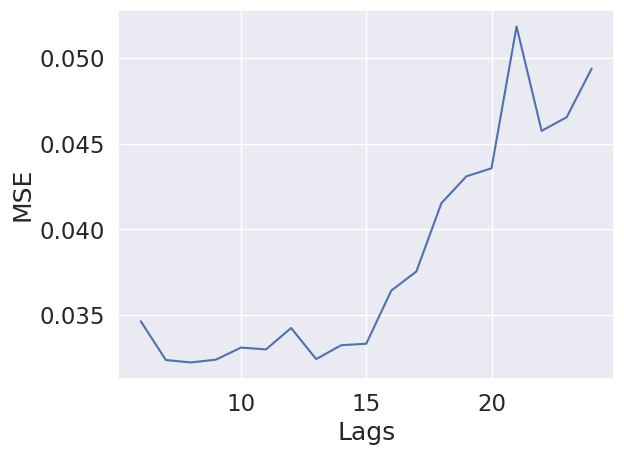

In [66]:
sns.lineplot(data=scores, x='Lags', y='MSE')

# Select one model

In [75]:
time_steps = 6
x_train, y_train = create_dataset(df_train, df_train, time_steps)
x_test, y_test = create_dataset(df_test, df_test, time_steps)

model = make_RNN_model(input_shape=(time_steps,1), layers_lstm=[64,64,32], return_sequences=[True, True, False], dense_layers=[32], activation='relu',
                       output=1, activation_out=None)
opt = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-2, epsilon=1e-5)
model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=20)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_split=0.15, epochs=1000, batch_size=512, verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/1000
4/4 [==============================] - 11s 374ms/step - loss: 0.0701 - mae: 0.1997 - mse: 0.0701 - val_loss: 0.0524 - val_mae: 0.1724 - val_mse: 0.0524 - lr: 0.0100
Epoch 2/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0317 - mae: 0.1361 - mse: 0.0317 - val_loss: 0.0164 - val_mae: 0.1034 - val_mse: 0.0164 - lr: 0.0100
Epoch 3/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0166 - mae: 0.1001 - mse: 0.0166 - val_loss: 0.0608 - val_mae: 0.1883 - val_mse: 0.0608 - lr: 0.0100
Epoch 4/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.0359 - mae: 0.1371 - mse: 0.0359 - val_loss: 0.0115 - val_mae: 0.0885 - val_mse: 0.0115 - lr: 0.0100
Epoch 5/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0096 - mae: 0.0758 - mse: 0.0096 - val_loss: 0.0597 - val_mae: 0.2237 - val_mse: 0.0597 - lr: 0.0100
Epoch 6/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0456 - mae: 0.1727 - mse: 0.0456 - val_loss

Text(0.5, 0, 'epochs')

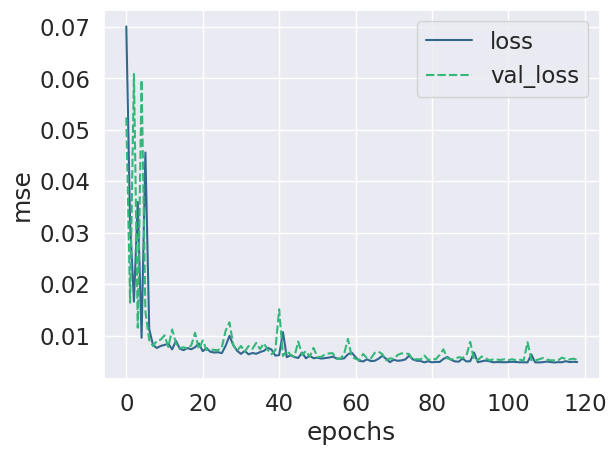

In [76]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('mse')
plt.xlabel('epochs')

In [77]:
y_pred = scaler.inverse_transform(model.predict(x_test)).flatten()
y_true = scaler.inverse_transform(y_test).flatten()

7/7 [==============================] - 1s 4ms/step


MAE: 11.058162054180498 and RMSE 14.992550289057627


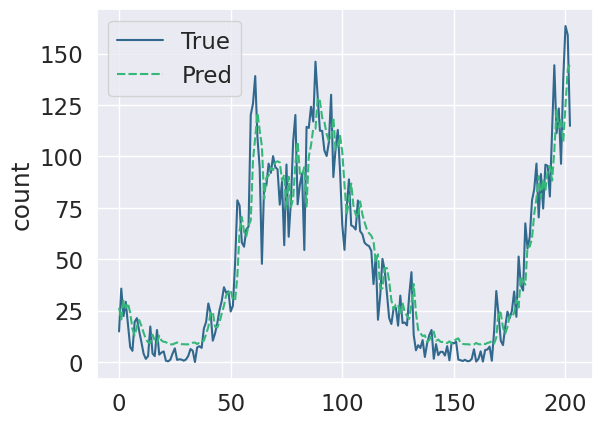

In [78]:
res = {'True': y_true, 'Pred': y_pred}
sns.lineplot(data=res, palette='viridis')
plt.ylabel('count')
print('MAE:', mean_absolute_error(y_true, y_pred), 'and RMSE', np.sqrt(mean_squared_error(y_true, y_pred)))